## Introduction

This notebook parses an output produced by the DENVIS web-service and compares the outputs with the results from the denvis paper.

It assumes that the denvis inference results have already been downloaded using the `download_extract_data.sh` script

Additionally, before making a request to the webservice the `drop_sdf_duplicates.py` script should be run on the sdf file containing the ligand library to be screened.

### Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

### Configuration

In [2]:
model_selection = 'refined' # 'refined' or 'general'

OUTPUT_TYPES = {
    "refined": ["y_score_Kd", "y_score_Ki"],
    "general": ["y_score_Kd", "y_score_Ki", "y_score_IC50"]
}

denvis_data_path = '../data/outputs/denvis_outputs' 

target_id = 'aa2ar'
output_type = OUTPUT_TYPES[model_selection]

### Specify App output path

In [3]:
output_path = "../webservice_data/aa2ar_denvis_webservice.json" # change it to the path of the webservice output

### Parse Webservice Output

In [4]:
raw_output_df = pd.read_json(output_path)

In [5]:
# keep = 'last' is important because that is how we dealt with duplicate ligands in our processing of DUD-E data
# some ligands are represented more than once in the DUD-E sdf files
output_df = raw_output_df.drop_duplicates(subset=['modality','version','ligand_id'], keep='last').reset_index(drop=True)

We store the ligand ids to query the denvis inference results

In [6]:
ligand_ids = output_df.ligand_id.unique()

### Load DENVIS results

In [7]:
if model_selection == "refined":
    denvis_atom = pd.read_parquet(os.path.join(denvis_data_path, 'dude_main_refined_atom.parquet') )
    denvis_surface = pd.read_parquet(os.path.join(denvis_data_path, 'dude_main_refined_surface.parquet') )
elif model_seltcion == "general": 
    denvis_atom = pd.read_parquet(os.path.join(denvis_data_path, 'dude_main_general_atom.parquet') )
    denvis_surface = pd.read_parquet(os.path.join(denvis_data_path, 'dude_main_general_surface.parquet') )

### Compare differences

Results should look the same apart from tiny differences due to rounding errors etc.

In [8]:
denvis_atom[denvis_atom['ligand_id'].isin(ligand_ids) & (denvis_atom['target_id'] == target_id)].sort_values(by=['ligand_id', 'version'])

,target_id,ligand_id,version,ckpt,y_true,y_score_Kd,y_score_Ki
162614,aa2ar,CHEMBL100382,0,0,1.0,2.725062,-2.583702
1578481,aa2ar,CHEMBL100382,1,0,1.0,6.586952,-2.676831
2994348,aa2ar,CHEMBL100382,2,0,1.0,4.622222,-1.560669
4410215,aa2ar,CHEMBL100382,3,0,1.0,3.490108,-4.556562
5826082,aa2ar,CHEMBL100382,4,0,1.0,2.344347,-2.827861
...,...,...,...,...,...,...,...
162669,aa2ar,CHEMBL95101,0,0,1.0,1.748837,0.855794
1578536,aa2ar,CHEMBL95101,1,0,1.0,1.122028,-1.689827
2994403,aa2ar,CHEMBL95101,2,0,1.0,5.853607,1.411649
4410270,aa2ar,CHEMBL95101,3,0,1.0,1.779458,-0.033722


In [9]:
output_df.query('modality == "atom"').sort_values(by=['ligand_id', 'version'])

,y_score_Kd,y_score_Ki,modality,version,ligand_id
33,2.725063,-2.583697,atom,version_0,CHEMBL100382
133,6.586952,-2.676835,atom,version_1,CHEMBL100382
233,4.622224,-1.560671,atom,version_2,CHEMBL100382
333,3.490108,-4.556561,atom,version_3,CHEMBL100382
433,2.344349,-2.827861,atom,version_4,CHEMBL100382
...,...,...,...,...,...
88,1.748838,0.855794,atom,version_0,CHEMBL95101
188,1.122028,-1.689828,atom,version_1,CHEMBL95101
288,5.853605,1.411651,atom,version_2,CHEMBL95101
388,1.779458,-0.033722,atom,version_3,CHEMBL95101


Indeed if we take the pairwise differences between the inference results provided in the repo and the output of the we should get differences in the order of $10^{-6}$

Text(0, 0.5, 'Count')

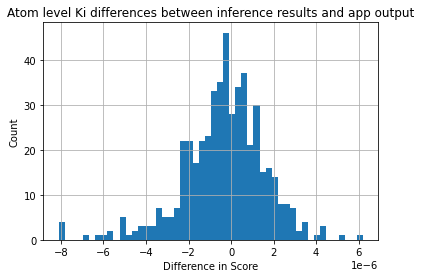

In [10]:
ki_denvis = denvis_atom[(denvis_atom['ligand_id'].isin(ligand_ids)) & (denvis_atom['target_id'] == target_id)].sort_values(by=['ligand_id', 'version']).reset_index()["y_score_Ki"]
ki_webservice = output_df.query('modality == "atom"').sort_values(by=['ligand_id', 'version']).reset_index()["y_score_Ki"]
(ki_denvis - ki_webservice).hist(bins=50)
plt.title('Atom level Ki differences between inference results and app output')
plt.xlabel('Difference in Score')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

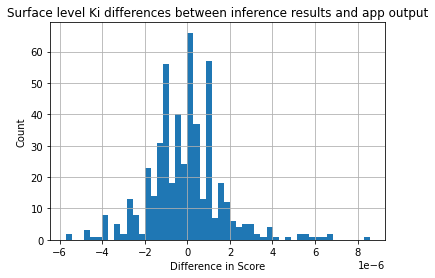

In [11]:
ki_denvis = denvis_surface[(denvis_surface['ligand_id'].isin(ligand_ids)) & (denvis_surface['target_id'] == target_id)].sort_values(by=['ligand_id', 'version']).reset_index()["y_score_Ki"]
ki_webservice = output_df.query('modality == "surface"').sort_values(by=['ligand_id', 'version']).reset_index()["y_score_Ki"]
(ki_denvis - ki_webservice).hist(bins=50)
plt.title('Surface level Ki differences between inference results and app output')
plt.xlabel('Difference in Score')
plt.ylabel('Count')

##### We can also calculate the ensemble score by averaging over versions, modalities and output types

In [12]:
averaged_df = output_df.groupby(['ligand_id'])[['y_score_Kd','y_score_Ki']].mean().reset_index(drop=False)
averaged_df['y_score'] = averaged_df[output_type].sum(axis=1) / len(output_type)

In [13]:
averaged_df

,ligand_id,y_score_Kd,y_score_Ki,score
0,CHEMBL100382,1.904883,0.692365,1.298624
1,CHEMBL1087462,1.615053,1.424461,1.519757
2,CHEMBL1087727,0.448480,1.279040,0.863760
3,CHEMBL1087820,1.374507,1.638831,1.506669
4,CHEMBL1088247,1.234403,1.427052,1.330727
...,...,...,...,...
95,CHEMBL77279,1.939756,1.800613,1.870185
96,CHEMBL81616,1.657878,1.365310,1.511594
97,CHEMBL85864,0.731613,1.624214,1.177913
98,CHEMBL87981,0.970803,1.689404,1.330103
